# Patchify a VIIRS mask

In [99]:
# imports
from importlib import reload
import h5py
import numpy as np
from skimage.transform import downscale_local_mean, resize_local_mean

import os

from matplotlib import pyplot as plt

from ulmo.plotting import plotting
from ulmo.enki import patch_analysis

# Load a VIIRS file 

In [117]:
viirs_file = os.path.join(os.getenv('OS_SST'), 'VIIRS',
                          'Extractions', 'VIIRS_2013_85clear_192x192_inpaint.h5')

In [118]:
f = h5py.File(viirs_file, 'r')
f.keys()

<KeysViewHDF5 ['fields', 'inpainted_masks', 'metadata']>

## Check a mask

In [8]:
f['inpainted_masks'][0]

array([[3.4777832, 3.477963 , 3.4783235, ...,       nan,       nan,
              nan],
       [3.4783752, 3.4785554, 3.4789166, ...,       nan,       nan,
              nan],
       [3.4795585, 3.47974  , 3.480102 , ...,       nan,       nan,
              nan],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan]], dtype=float32)

In [13]:
mask = np.isfinite(f['inpainted_masks'][0])
np.sum(mask)/(192**2)

0.13685438368055555

In [14]:
mask.shape

(192, 192)

# Rebin

In [23]:
r_mask = downscale_local_mean(mask, (3, 3)) > 0
r_mask = r_mask.astype(int)
r_mask.shape

(64, 64)

In [24]:
r_mask

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

# Patchify

In [25]:
p_sz = 4

In [35]:
patches = np.zeros((64//p_sz, 64//p_sz), dtype=int)
patches.shape

(16, 16)

## Indices

In [36]:
mask_idx = np.where(r_mask)
#mask_idx

## Turn em on

In [37]:
p_idx = (mask_idx[0]//p_sz, mask_idx[1]//p_sz)
patches[p_idx] = 1

In [38]:
patches

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0]])

## Now in 64x64

In [47]:
new_mask = np.zeros((64,64),dtype=int)

In [48]:
all_pix = np.unravel_index(np.arange(new_mask.size), new_mask.shape)

In [62]:
all_patches = (all_pix[0]//p_sz, all_pix[1]//p_sz)

In [65]:
in_patch = patches[all_patches]

In [80]:
new_mask = in_patch.reshape((64,64)) 

# Check

In [40]:
orig = f['fields'][0,...]
orig.shape

(192, 192)

<Axes: >

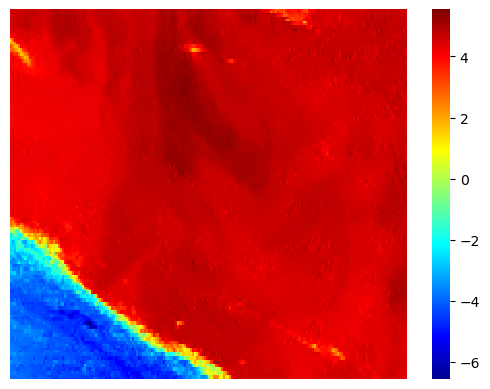

In [42]:
plotting.show_image(orig)

In [44]:
rebin_orig = downscale_local_mean(orig, (3,3))

<Axes: >

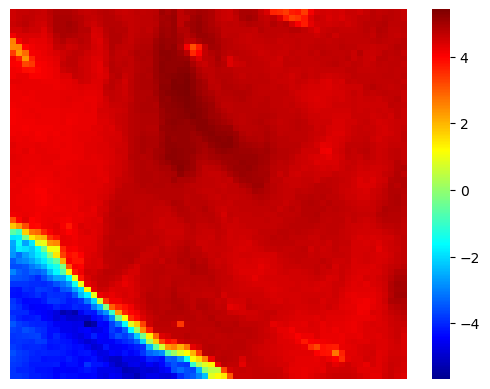

In [45]:
plotting.show_image(rebin_orig)

<Axes: >

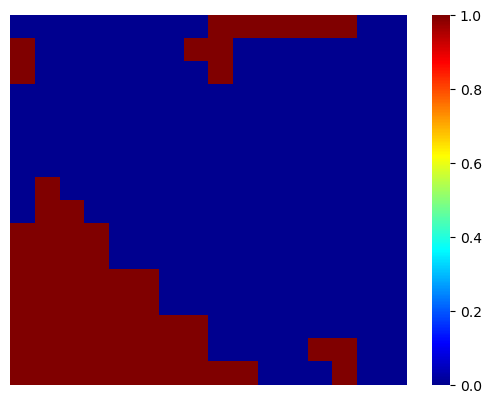

In [72]:
plotting.show_image(new_mask)

<Axes: >

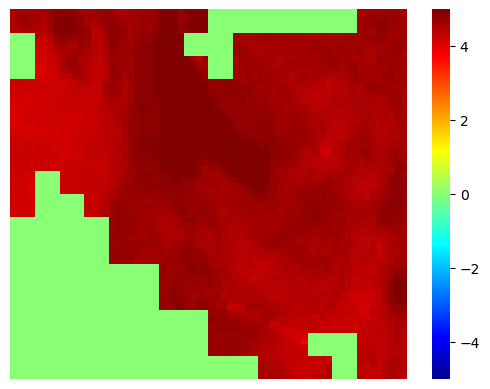

In [81]:
plotting.show_image(rebin_orig*(1-new_mask), vmnx=(-5,5))

---- 

# Now as a simple algorithm

In [132]:
idx = 2500
mask = np.isfinite(f['inpainted_masks'][idx])
orig = f['fields'][idx,...]

## Rebin

In [133]:
#r_mask = downscale_local_mean(mask, (3, 3)) > 0
#r_mask = r_mask.astype(int)
r_orig = downscale_local_mean(orig, (3,3))

In [136]:
new_mask = patch_analysis.patchify_mask(mask, 4, rebin=(3,3))

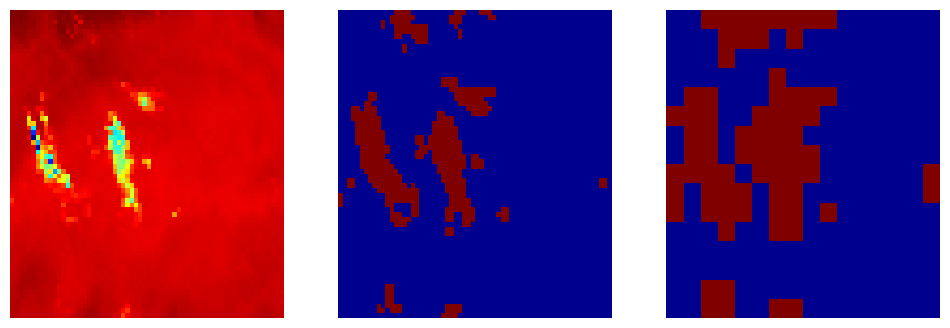

In [144]:
_f, ax = plt.subplots(1,3, figsize=(12,4))
#
plotting.show_image(r_orig, ax=ax[0], cbar=False)
plotting.show_image(r_mask, ax=ax[1], cbar=False)#, cm='Greys')
plotting.show_image(new_mask, ax=ax[2], cbar=False)#, cm='Greys')


plt.show()

In [139]:
np.sum(mask)/192**2, np.sum(new_mask)/64**2

(0.07828776041666667, 0.28125)

In [128]:
reload(patch_analysis)

<module 'ulmo.enki.patch_analysis' from '/home/xavier/Projects/Oceanography/python/ulmo/ulmo/enki/patch_analysis.py'>

In [130]:
new_mask2 = patch_analysis.patchify_mask(mask, 4, rebin=(3,3))

<Axes: >

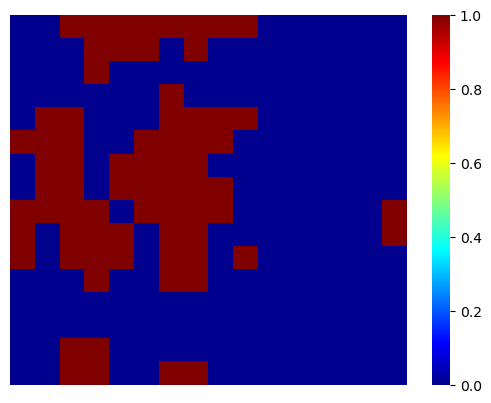

In [131]:
plotting.show_image(new_mask2)

In [145]:
f.close()